In [1]:
import mne
import numpy as np
import pandas as pd 
import os
from scipy.signal import welch, get_window
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.signal import welch, get_window
from fooof.sim.gen import gen_aperiodic
from fooof import FOOOF
from fooof.core.funcs import expo_nk_function, gaussian_function
from sklearn.metrics import mean_absolute_error, r2_score

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
def welch_method(file_path):
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    channel_name = raw.info['ch_names']
    channel_index = []
    channel_data = []
    channel_time = []
    frequencies = []
    psd = []
    for i in range(19):
        index = raw.ch_names.index(channel_name[i])
        data = raw[index, :][0] * 1e6
        time = raw[index, :][1] 

        channel_index.append(index)
        channel_data.append(data)
        channel_time.append(time)
        N = 1024  
        nfft = 2 ** int(np.ceil(np.log2(N)))
        freqs, power = welch(channel_data[i], fs=raw.info['sfreq'], nfft=nfft, window = get_window('hamming',256), noverlap=125, scaling='density')
        
        power = power.flatten()
        idx = (freqs >= 0) & (freqs <= 50)
        freqs = freqs[idx]
        power = power[idx]

        frequencies.append(freqs)
        psd.append(power)
    return frequencies, psd

In [3]:
import numpy as np
from scipy.ndimage import uniform_filter1d

def detect_plateau_onset_x(freq, psd, f_start=10, f_max=50, thresh_slope=0.05, window=5):
    """
    Phát hiện vùng phổ phẳng bằng cách tìm khoảng tần số có độ dốc thấp.
    
    Parameters
    ----------
    freq : ndarray
        Mảng tần số.
    psd : ndarray
        Mảng mật độ phổ công suất (PSD).
    f_start : float, optional
        Tần số bắt đầu tìm kiếm. Default là 10 Hz.
    f_max : float, optional
        Tần số tối đa để tìm kiếm plateau. Default là 50 Hz.
    thresh_slope : float, optional
        Ngưỡng độ dốc để phát hiện plateau. Default là 0.05.
    window : int, optional
        Kích thước cửa sổ trung bình hóa độ dốc để giảm nhiễu. Default là 5.

    Returns
    -------
    float or None
        Tần số bắt đầu của plateau nếu tìm thấy, ngược lại trả về None.
    """
    mask = (freq >= f_start) & (freq <= f_max)
    freq, psd = freq[mask], psd[mask]

    log_freq = np.log10(freq)
    log_psd = np.log10(psd)

    slopes = np.gradient(log_psd, log_freq)

    slopes_smooth = uniform_filter1d(slopes, size=window)

    plateau_indices = np.where(np.abs(slopes_smooth) < thresh_slope)[0]
    
    if len(plateau_indices) > 0:
        return freq[plateau_indices[0]]  
    
    return 40  

def detect_plateau_onset(freq, psd, f_start, f_range=10, thresh=0.05,
                         step=1, reverse=False,
                         ff_kwargs=dict(verbose=False, max_n_peaks=1)):
    """
    Detect the plateau of a power spectrum with 1/f exponent beta < threshold.
    """
    exp = np.inf
    fm = FOOOF(**ff_kwargs)
    max_freq = np.max(freq)
    min_freq = np.min(freq)

    while exp > thresh:
        if reverse:
            f_start -= step
            if f_start - f_range < min_freq:
                return 45
            freq_range = [f_start - f_range, f_start]
        else:
            f_start += step
            if f_start + f_range > max_freq:
                return 45
            freq_range = [f_start, f_start + f_range]

        try:
            fm.fit(freq, psd, freq_range)
            exp = fm.get_params('aperiodic_params', 'exponent')
        except Exception as e:
            print(f"FOOOF fitting failed at freq_range={freq_range}: {e}")
            return 45

    return f_start + f_range // 2



In [4]:
set_file = 'D:\\K66K1\\NCKH 2025\\Data\\AD\\sub-035_task-eyesclosed_eeg.set'
frequencies, psds = welch_method(set_file)
# for i in range(19):
#     freq = frequencies[i]
#     psd = psds[i]
#     for w in [3, 5, 7, 10]:
#         plateau_freq = detect_plateau_onset(freq, psd, f_start=20, window=w)
#         print(f"Window {w}: Tần số plateau = {plateau_freq}")
#     #plateau_onset_sim = detect_plateau_onset(freq, psd, f_start=20, window=3)
#     #print(plateau_onset_sim)
#     plt.plot(freq, 10 * np.log10(psd))
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Power Spectral Density (dB)")
#     plt.title("Power Spectral Density using Welch's Method")
#     plt.grid()
#     plt.show()

Reading D:\K66K1\NCKH 2025\Data\AD\sub-035_task-eyesclosed_eeg.fdt
Reading 0 ... 370519  =      0.000 ...   741.038 secs...


c:\Users\Hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymatreader\utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
C:\Users\Hi\AppData\Local\Temp\ipykernel_9632\2399435988.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


In [ ]:
import numpy as np
from fooof import FOOOF
import matplotlib.pyplot as plt 

def fooof_tool(frequencies, psd, plot_each_channel=True):
    """
    Thực hiện FOOOF fit, tính toán lỗi khớp của thành phần không tuần hoàn
    theo phương pháp (phổ gốc - mô hình tuần hoàn) so với mô hình không tuần hoàn,
    và tùy chọn vẽ đồ thị so sánh cho mỗi kênh.

    LƯU Ý: Phương pháp tính lỗi này có hạn chế vì sai số trong mô hình tuần hoàn
    sẽ ảnh hưởng đến kết quả.

    Args:
        frequencies (list or array): Danh sách hoặc mảng các mảng tần số cho mỗi kênh.
        psd (list or array): Danh sách hoặc mảng các mảng phổ công suất (TUYẾN TÍNH)
                             tương ứng cho mỗi kênh.
        plot_each_channel (bool): Nếu True, vẽ đồ thị so sánh cho mỗi kênh.

    Returns:
        tuple: Chứa hai danh sách: (r2s_list, mae_list).
    """
    mae_list = []
    r2s_list = []

    # Sử dụng len() thay vì số cứng
    num_channels = len(frequencies)
    if num_channels != len(psd):
        raise ValueError("Số lượng mảng tần số và mảng PSD phải bằng nhau.")

    for i in range(num_channels):
        # Khởi tạo FOOOF object cho mỗi kênh
        fm_aperiodic = FOOOF(peak_width_limits=[1, 12], max_n_peaks=1, min_peak_height=0.01,
                             peak_threshold=-5, aperiodic_mode='fixed', verbose=False)

        freqs_channel = np.array(frequencies[i]).flatten() # Đảm bảo là numpy array
        power_linear = np.array(psd[i]).flatten()         # Đảm bảo là numpy array và là CÔNG SUẤT TUYẾN TÍNH

        # Kiểm tra giá trị đầu vào (nên kiểm tra trên công suất tuyến tính)
        # if np.any(power_linear <= 0):
        #      print(f"Cảnh báo: Kênh {i+1} chứa giá trị PSD không dương. Cần xử lý hoặc bỏ qua.")
        #      # Ví dụ: thay thế bằng giá trị nhỏ hoặc NaN, hoặc bỏ qua kênh
        #      # power_linear[power_linear <= 0] = 1e-16 # Thay bằng số rất nhỏ
        #      # Hoặc bỏ qua:
        #      mae_list.append(np.nan)
        #      r2s_list.append(np.nan)
        #      print(f"Bỏ qua kênh {i+1} do giá trị PSD không hợp lệ.")
        #      continue # Bỏ qua lần lặp này

        try:
            plateau_start = detect_plateau_onset(frequencies[i], psd[i], f_start=20) 
            freq_range_aperiodic = [2, 45]
            # Sử dụng .fit() và truyền công suất TUYẾN TÍNH vào
            # report() chỉ là fit() + in ra kết quả, bạn có thể dùng fit() nếu không muốn in
            # fm_aperiodic.fit(freqs_channel, power_linear, freq_range_aperiodic)
            fm_aperiodic.report(freqs_channel, power_linear, freq_range_aperiodic)

            # Lưu report PDF
            report_path = f'fooof_pe_ape_report_channel_{i+1}.pdf'
            fm_aperiodic.save_report(report_path)

            # Lấy các thành phần đã được fit từ đối tượng FOOOF (chúng ở dạng log10)
            # Phổ gốc (đã log10 và giới hạn tần số) dùng để fit
            power_spectrum_log10_fitted = fm_aperiodic.power_spectrum
            # Thành phần không tuần hoàn được mô hình hóa (log10)
            aperiodic_fit = fm_aperiodic._ap_fit
            # Thành phần tuần hoàn được mô hình hóa (tổng các Gaussian, log10)
            periodic_fit = fm_aperiodic._peak_fit
            # Tần số tương ứng với các mảng trên (trong freq_range)
            freqs_fitted = fm_aperiodic.freqs

            # Kiểm tra xem fit có thành công không (các thành phần không phải None)
            if power_spectrum_log10_fitted is not None and periodic_fit is not None and aperiodic_fit is not None and freqs_fitted is not None:
                # Tính toán "phần còn lại" sau khi trừ mô hình tuần hoàn (trong không gian log10)
                psd_minus_periodic_model = power_spectrum_log10_fitted - periodic_fit

                # --- Tính toán lỗi ---
                mae = mean_absolute_error(psd_minus_periodic_model, aperiodic_fit)
                r2s = r2_score(psd_minus_periodic_model, aperiodic_fit)
                mae_list.append(mae)
                r2s_list.append(r2s)

                # --- Vẽ đồ thị (nếu được yêu cầu) ---
                if plot_each_channel:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    # Vẽ mô hình không tuần hoàn
                    ax.plot(freqs_fitted, aperiodic_fit, label='Phổ 1/f trích xuất từ thuật toán', linewidth=2.5, color='red')
                    # Vẽ phổ gốc trừ đi mô hình tuần hoàn
                    ax.plot(freqs_fitted, psd_minus_periodic_model, label='Phổ 1/f sau khi loại bỏ đỉnh', linestyle='--', color='blue')

                    ax.set_xlabel("Tần số (Hz)")
                    ax.set_ylabel("Log10 Power")
                    ax.set_title(f"Kênh {i+1}: Đánh giá độ chính xác mô hình hóa thành phần 1/f")
                    text_str = f"MAE = {mae:.4f}\nR² = {r2s:.4f}"
                    ax.text(0.98, 0.95, text_str, transform=ax.transAxes,
                            fontsize=12, verticalalignment='top', horizontalalignment='right',
                            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
                    ax.legend()
                    ax.grid(True, linestyle=':', alpha=0.7)
                    output_path = f'fooof_ape_channel_{i+1}.pdf'  # hoặc .png tùy bạn muốn
                    fig.savefig(output_path, bbox_inches='tight')  # đảm bảo không bị cắt góc

                    plt.close(fig)

            else:
                 print(f"FOOOF fit có thể đã thất bại hoặc trả về None cho kênh {i+1}. Bỏ qua tính toán lỗi và vẽ đồ thị.")
                 mae_list.append(np.nan)
                 r2s_list.append(np.nan)

        except Exception as e:
            print(f"FOOOF fit thất bại cho kênh {i+1}: {e}")
            # Thêm giá trị NaN hoặc xử lý lỗi khác nếu cần
            mae_list.append(np.nan)
            r2s_list.append(np.nan)

    return r2s_list, mae_list


c:\Users\Hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\fooof\core\reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
c:\Users\Hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\fooof\core\reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
c:\Users\Hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\fooof\core\reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(fpath(file_path, fname(file_name, SAVE_FORMAT)))
c:\Users\Hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\fooof\core\reports.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so res

([0.9212742216078675, 0.9781730291259881, 0.9524697113719388, 0.9766845839314726, 0.9879574832560519, 0.9777755431399708, 0.9559941369159385, 0.9781949486243077, 0.9268076502259953, 0.9521536898369994, 0.9829299600694175, 0.9775565249020547, 0.9003978146843431, 0.9120209337807182, 0.9280858312134547, 0.9341943348235944, 0.9874271768628332, 0.987313675227407, 0.9843801935519281], [0.10252896220338457, 0.050697793245818, 0.06893584000529883, 0.04738934128282784, 0.03301894228542624, 0.044199180172710836, 0.06508064509255809, 0.05301403310853082, 0.09536622487239434, 0.09444121547685662, 0.05637605034352495, 0.06062657365375156, 0.07576961368404185, 0.05140086971676808, 0.06841149470749136, 0.08597507938941537, 0.04686378043269124, 0.04940624380729262, 0.04875962517587161])


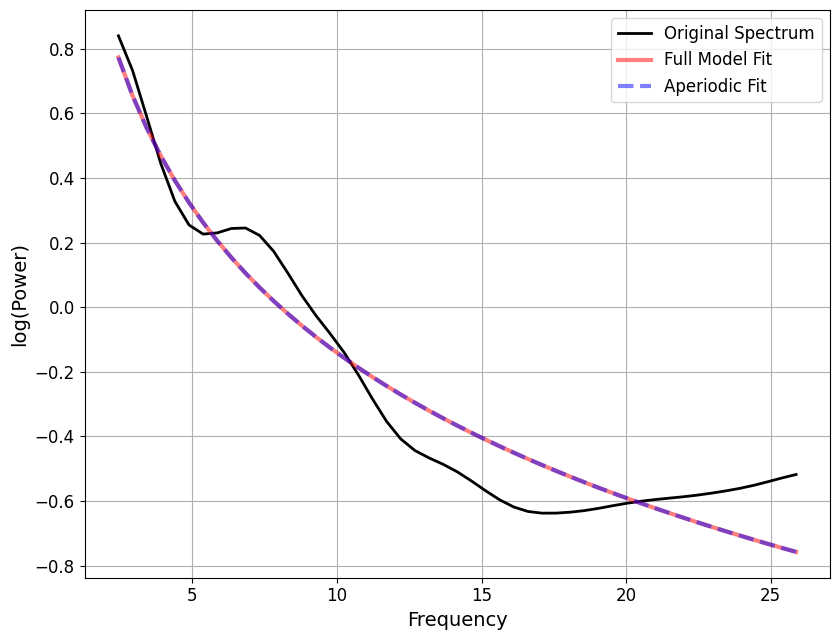

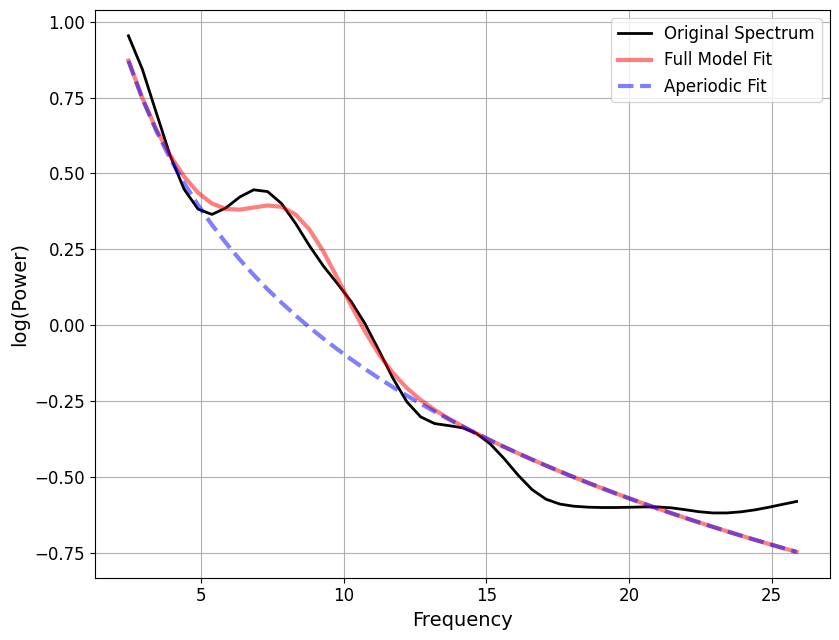

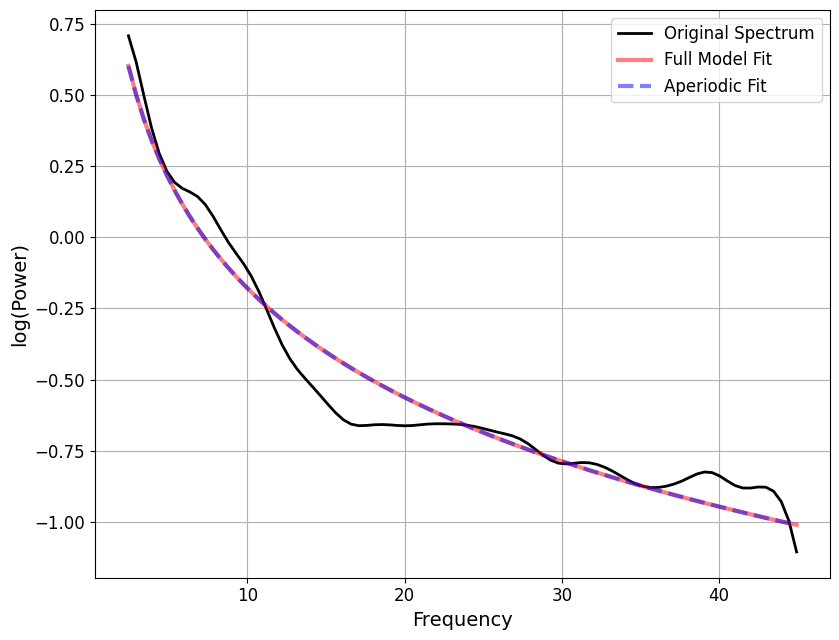

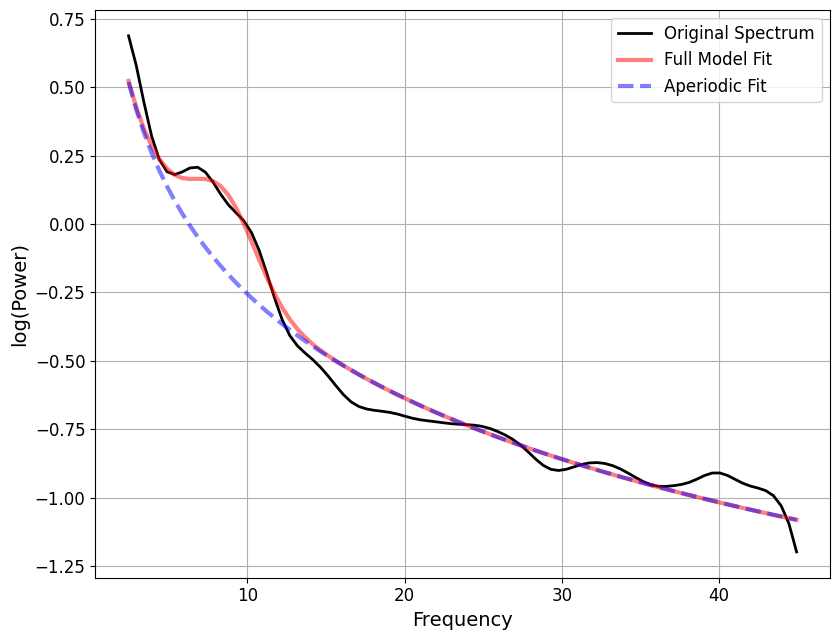

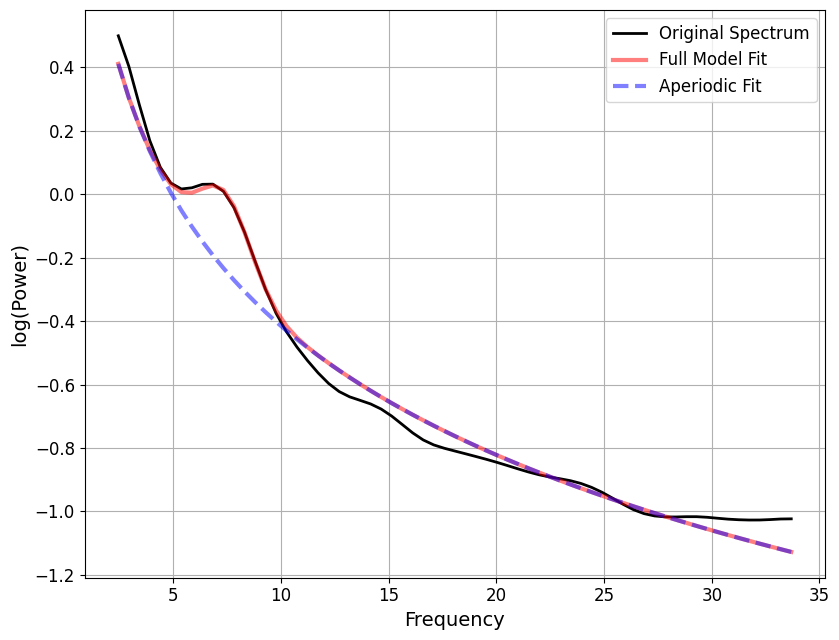

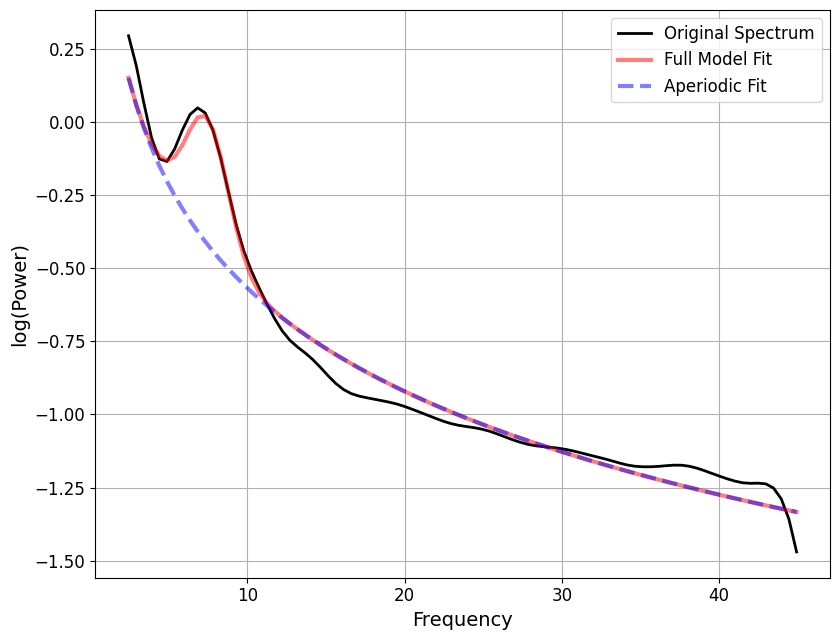

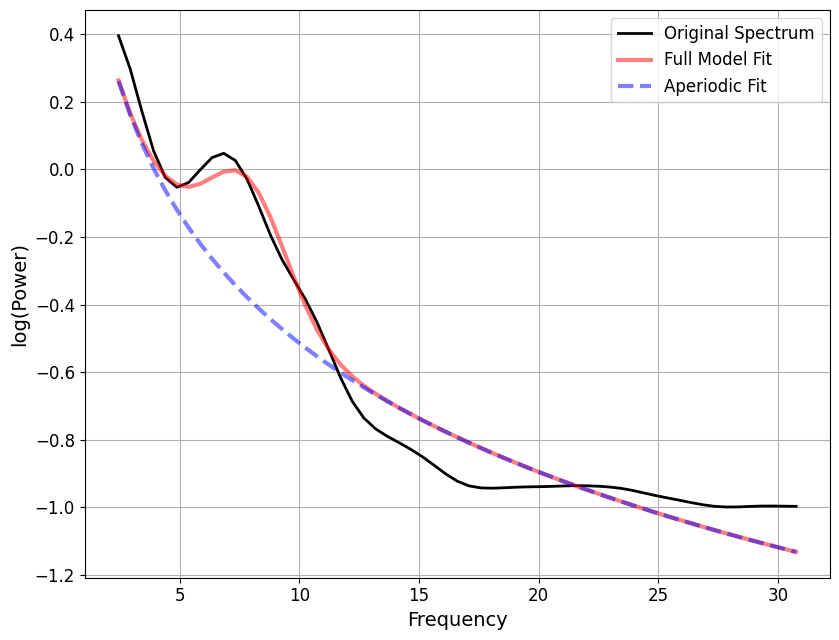

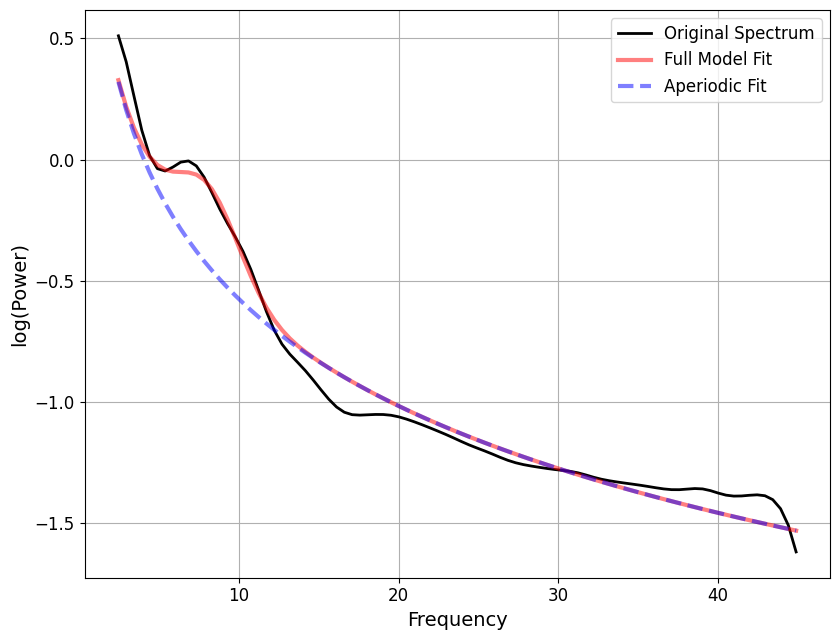

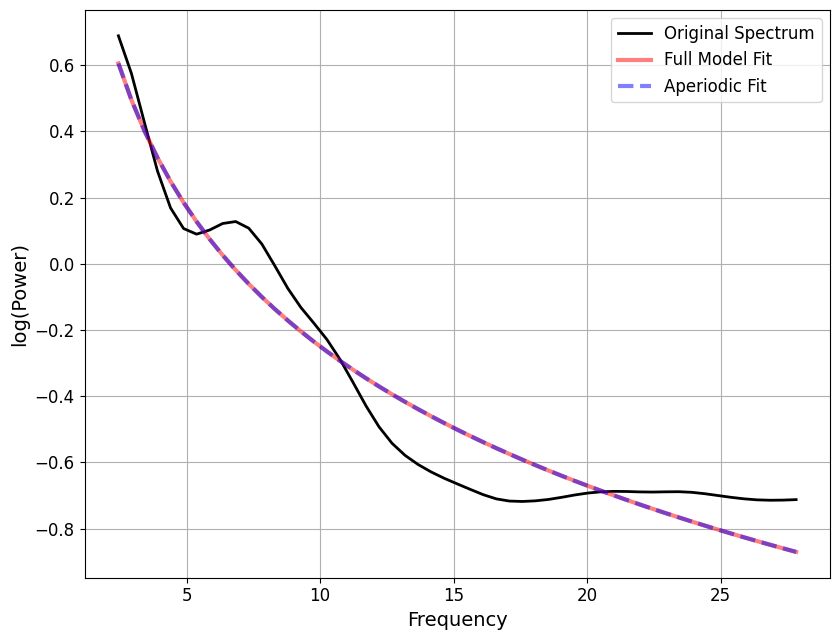

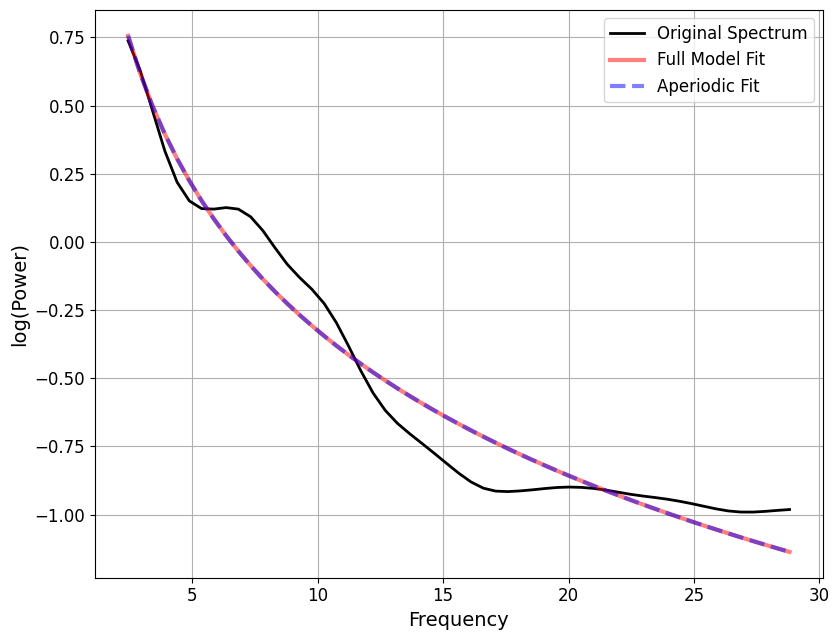

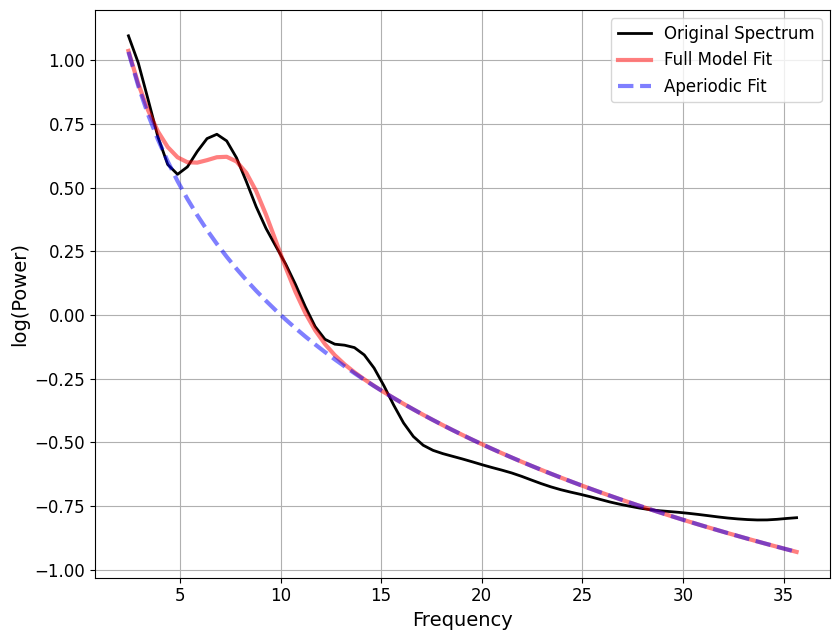

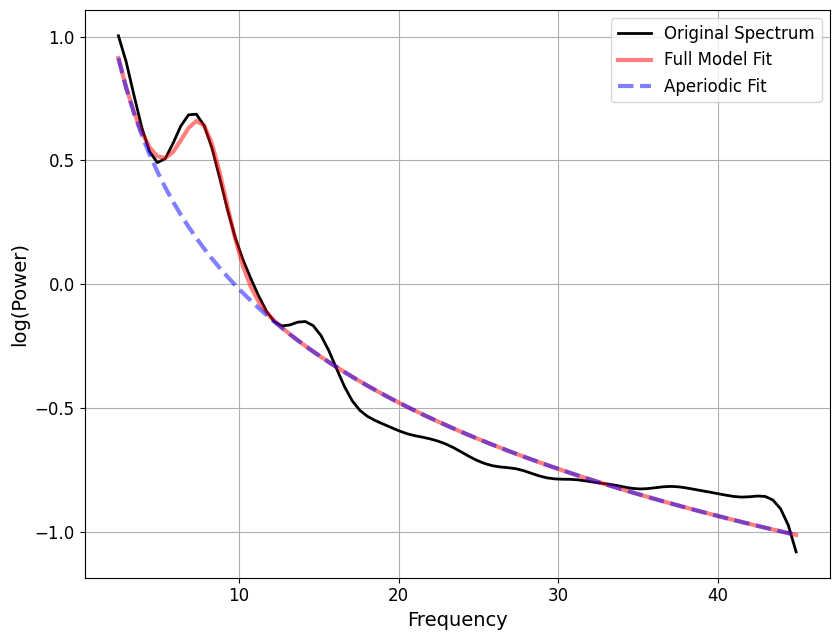

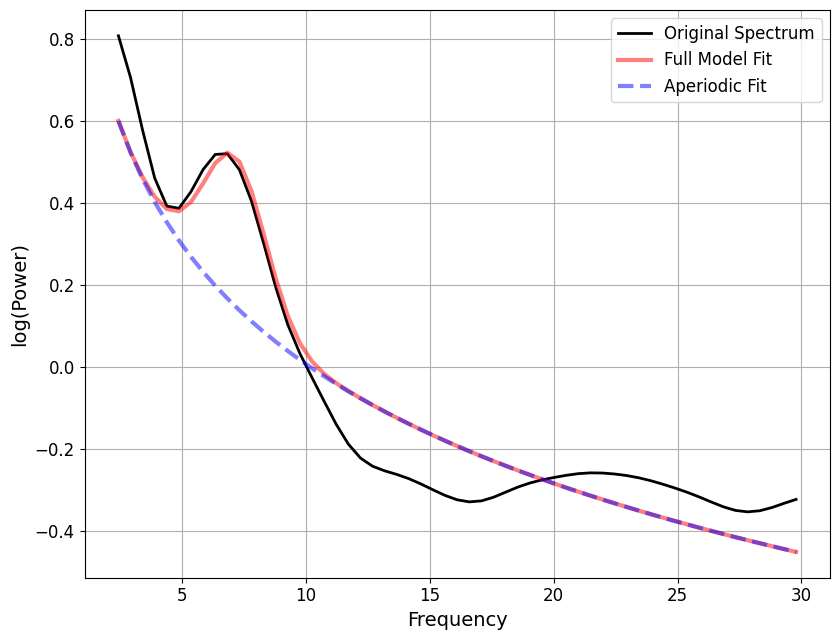

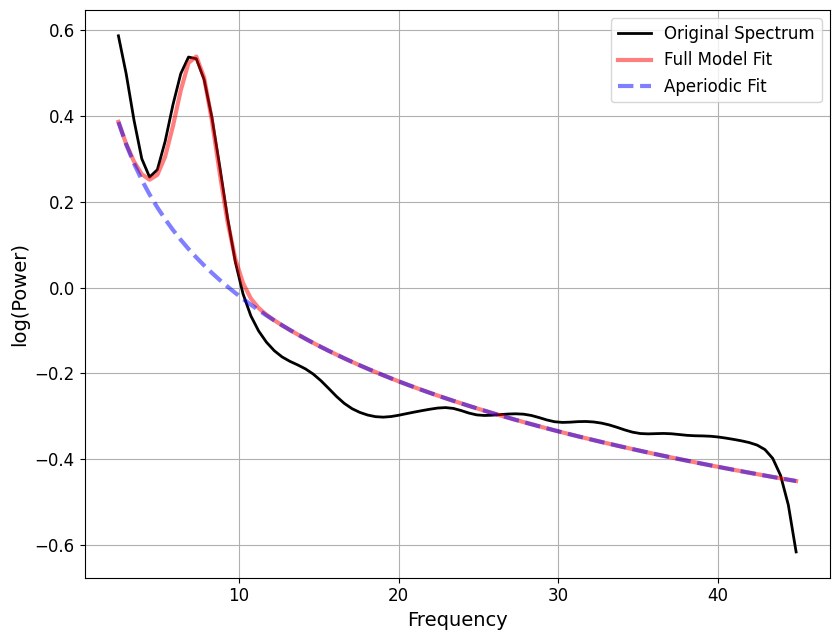

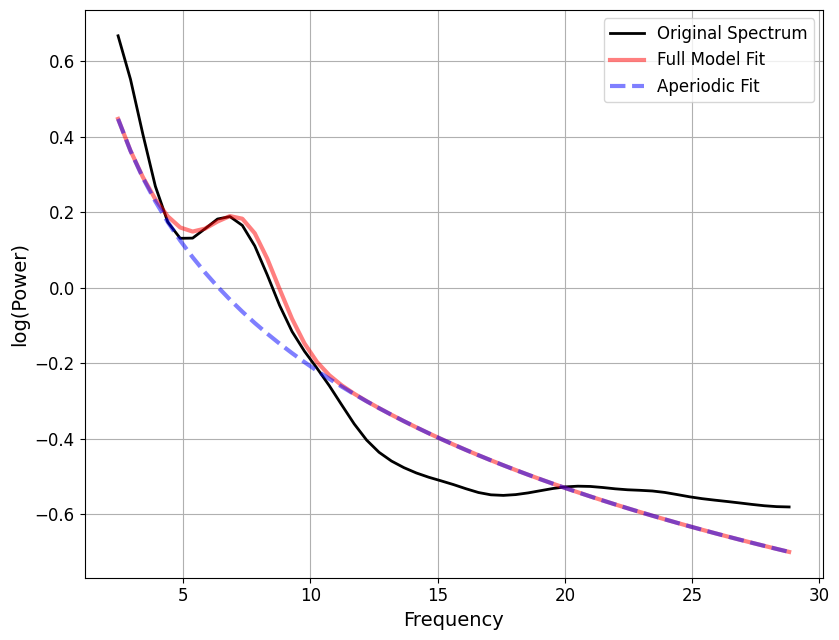

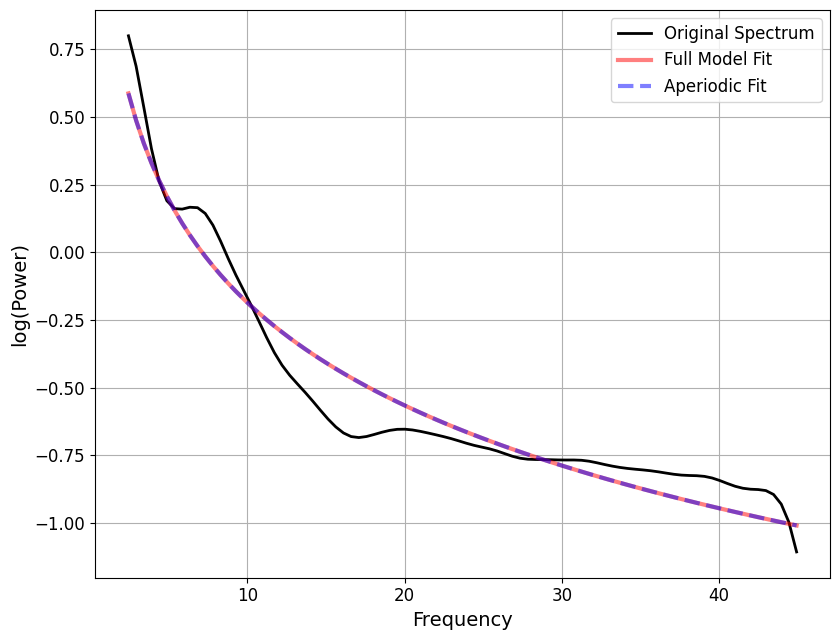

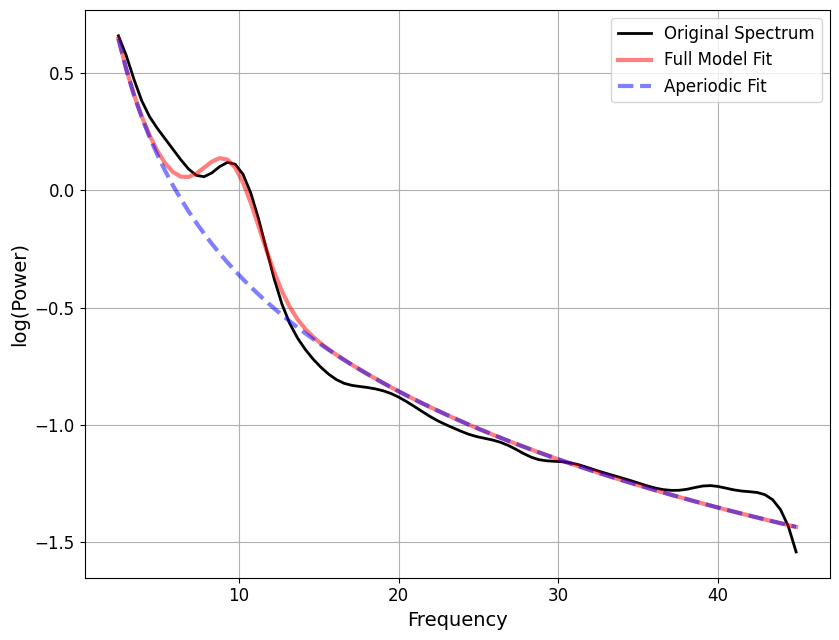

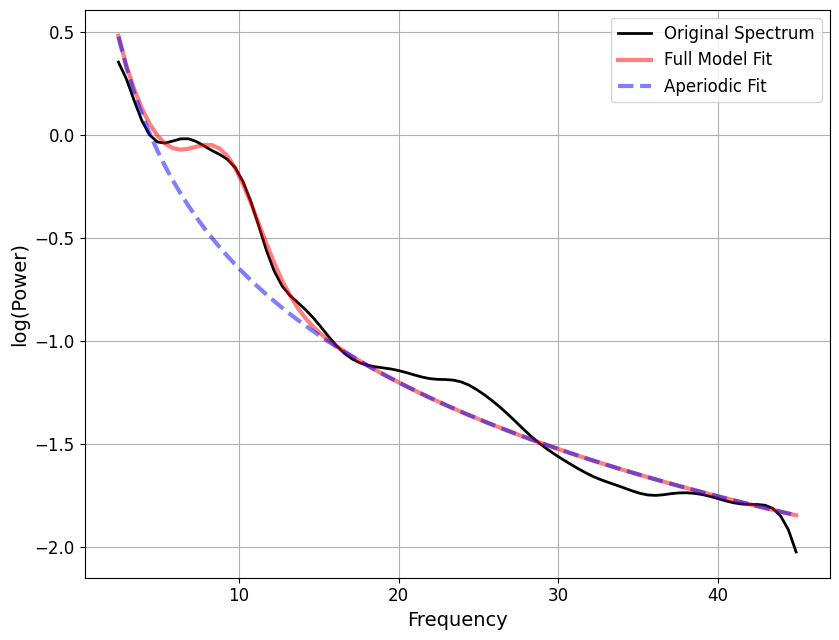

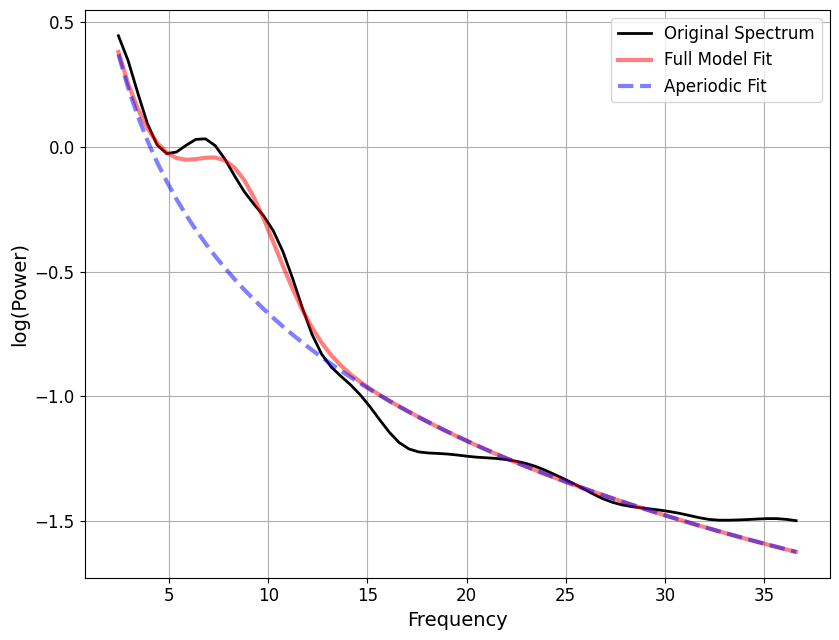

In [10]:
print(fooof_tool(frequencies, psds))

In [20]:
import numpy as np
from fooof import FOOOF
from scipy.optimize import minimize

def fooof_tool(frequencies, psd, lambda_reg=0.1, max_peaks_init=1):
    all_features = []
    mae_values = []
    peak_counts = []
    
    print("\n=== FOOOF Analysis Report ===")
    
    for i in range(19):
        freq_range_periodic = [0.01, 16]
        freq_range_aperiodic = [2, 40]  # Dải tần rộng hơn cho thành phần không tuần hoàn
        
        frequencies[i] = frequencies[i].flatten()
        psd[i] = psd[i].flatten()
        
        # Hàm mất mát tối ưu số đỉnh
        def loss_function(max_n_peaks):
            #max_n_peaks = int(max_n_peaks[0])
            
            fm_periodic = FOOOF(peak_width_limits=[1, 12], max_n_peaks=max_n_peaks, 
                                min_peak_height=0.01, peak_threshold=0, 
                                aperiodic_mode='fixed', verbose=False)
            
            try:
                fm_periodic.fit(frequencies[i], psd[i], freq_range_periodic)
                mae = fm_periodic.get_params('error')
                peak_count = len(fm_periodic.get_params('peak_params'))
                return mae + lambda_reg * peak_count  # Regularization
            except:
                return np.inf 
        
        # Tìm số đỉnh tối ưu
        result = minimize(loss_function, [max_peaks_init], method='L-BFGS-B', bounds=[(1, 10)])
        optimal_peaks = int(result.x[0])
        
        # Mô hình hóa thành phần tuần hoàn (chỉ lấy đỉnh có power cao nhất)
        fm_periodic = FOOOF(peak_width_limits=[1, 12], max_n_peaks=optimal_peaks,
                            min_peak_height=0.01, peak_threshold=0, aperiodic_mode='fixed', verbose=False)
        
        # Mô hình hóa thành phần không tuần hoàn
        fm_aperiodic = FOOOF(peak_width_limits=[1, 12], max_n_peaks=100, 
                             min_peak_height=0.01, peak_threshold=-5, 
                             aperiodic_mode='fixed', verbose=False)

        try:
            # Fit periodic model
            fm_periodic.report(frequencies[i], psd[i], freq_range_periodic)
            peak_params = fm_periodic.get_params('peak_params')

            # Chọn đỉnh có power cao nhất
            if peak_params is not None and len(peak_params) > 0:
                max_power_idx = np.argmax(peak_params[:, 1])  # Lấy đỉnh có PW cao nhất
                best_peak = peak_params[max_power_idx]  # (CF, PW, BW)
            else:
                best_peak = np.array([0, 0, 0])  # Không có đỉnh nào
            
            # Fit aperiodic model
            fm_aperiodic.report(frequencies[i], psd[i], freq_range_aperiodic)
            aperiodic_params = fm_aperiodic.get_params('aperiodic_params')
            
            offset = aperiodic_params[0] if aperiodic_params is not None else 0
            exponent = aperiodic_params[1] if aperiodic_params is not None else 0
            
            # Lưu đặc trưng
            features = np.concatenate((best_peak, [offset, exponent]))  # (CF, PW, BW, Offset, Exponent)
            all_features.extend(features)
            
            # Lưu MAE và số đỉnh
            mae = fm_periodic.get_params('error')
            num_peaks = len(fm_periodic.get_params('peak_params'))
            mae_values.append(mae)
            peak_counts.append(num_peaks)
            
            # Báo cáo kết quả
            print(f"\n[Channel {i+1}]")
            print(f"  - Optimal Peaks: {optimal_peaks}")
            print(f"  - Fit Quality (MAE): {mae:.4f}")
            print(f"  - Extracted Peaks: {num_peaks}")
            print(f"  - Best Peak (CF: {best_peak[0]:.2f} Hz, PW: {best_peak[1]:.2f}, BW: {best_peak[2]:.2f} Hz)")
            print(f"  - Aperiodic Offset: {offset:.2f}, Exponent: {exponent:.2f}")
        
        except Exception as e:
            print(f"\n[Channel {i+1}] FOOOF fit failed: {e}")
            features = np.array([0, 0, 0, 0, 0])
            all_features.extend(features)
            mae_values.append(np.inf)
            peak_counts.append(0)

    return np.array(all_features), np.array(mae_values), np.array(peak_counts)


In [ ]:
set_file = 'D:\\K66K1\\NCKH 2025\\Data\\AD\\sub-002_task-eyesclosed_eeg.set'
frequencies, psd = welch_method(set_file)
fooof_tool(frequencies, psd)